In [1]:
from config import config
from data import preprocess 
from utils import utils
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow as tf
from tqdm import tqdm
import pickle
from keras.utils.vis_utils import plot_model
captions_path = '.\\datasets\\captions.csv'
img_dir_path = '.\\datasets\\images'
start_tkn = "starttkn"
end_tkn = "endtkn"


Using TensorFlow backend.


In [2]:
print("{} {}".format(img_dir_path, captions_path))
preprocess.get_data_list

.\datasets\images .\datasets\captions.csv


<function data.preprocess.get_data_list(cap_path, start_tkn='<start>', end_tkn='<end>')>

In [3]:
res  = preprocess.get_data_list(captions_path, start_tkn = "starttkn", end_tkn = "endtkn")
res[0][0]

'./datasets/images/3571675421.jpg'

In [4]:
image_list ,word_list = np.split(res, 2, 1)
word_list = word_list.reshape(len(word_list))
image_list = image_list.reshape(len(image_list))
image_desc = {}

In [5]:
max_len = 0
image_desc = {}
for data in zip(image_list, word_list):
    img = data[0]
    text = data[1]
    if img not in image_desc:
        image_desc[img] = []
    image_desc[img].append(text)
    max_len = max(max_len , len(text.split()))
    #if len(text.split()) == max_len:
    #    print(text)
#image_desc

In [6]:
max_words = 5000
tokenizer = Tokenizer(num_words=max_words)

In [7]:
tokenizer.fit_on_texts(word_list)

In [8]:
word_list_vec = tokenizer.texts_to_sequences(word_list)
word_list_vec = preprocessing.sequence.pad_sequences(word_list_vec , padding='post')

In [9]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [10]:
max_words = max_words + 1

In [11]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [12]:
max_len = calc_max_length(word_list_vec)

In [13]:
max_len

72

In [14]:
word_index = tokenizer.word_index

In [15]:
start_tkn_idx = tokenizer.word_index[start_tkn]
print(start_tkn_idx)
end_tkn_idx = tokenizer.word_index[end_tkn]
print(end_tkn_idx)

1
2


In [16]:
tokenizer.index_word[0] = ''

In [17]:
encode_model = InceptionV3(weights='imagenet')
encode_model = Model(encode_model.input, encode_model.layers[-2].output)
WIDTH = 299
HEIGHT = 299
OUTPUT_DIM = 2048
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [18]:
def encodeImage(img, output_dim):
  # Resize all images to a standard size (specified bythe image encoding network)
  #img = img.resize((width, height), Image.ANTIALIAS)
  # Convert a PIL image to a numpy array
  x = keras.preprocessing.image.img_to_array(img)
  # Expand to 2D array
  x = np.expand_dims(x, axis=0)
  # Perform any preprocessing needed by InceptionV3 or others
  x = preprocess_input(x)
  # Call InceptionV3 (or other) to extract the smaller feature set for the image.
  x = encode_model.predict(x) # Get the encoding vector for the image
  #print(x.shape)
  # Shape to correct form to be accepted by LSTM captioning network.
  x = np.reshape(x, output_dim)
  return x

In [19]:
encoding_train_dict = {}
encoding_path = "./data/captions/encoding.pkl"
if not os.path.exists(encoding_path):
    for img_path in image_list:
        if img_path not in encoding_train_dict:
            img = keras.preprocessing.image.load_img(img_path, target_size=(HEIGHT, WIDTH))
            encoding_train_dict[img_path] = encodeImage(img,OUTPUT_DIM )
    with open(encoding_path, "wb") as fp:
        pickle.dump(encoding_train_dict, fp)
else:
    with open(encoding_path, "rb") as fp:
        encoding_train_dict = pickle.load(fp)

In [20]:
len(encoding_train_dict['./datasets/images/3653385929.jpg'])

2048

In [21]:
def data_gen(image_path_list, text_list):
    n = 0
    x1, x2, y = [], [] ,[]
    cnt = 0
    while True:
        for train in zip(image_path_list, text_list):
            n += 1
            #print(cnt)
            img = encoding_train_dict[train[0]]
            seq = train[1]

            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                #print(in_seq)
                #print(len(in_seq))
                in_seq = pad_sequences([in_seq], maxlen=max_len)[0]
                #print(type(in_seq), len(in_seq), in_seq)
                #print(out_seq)
                out_seq = to_categorical([out_seq], num_classes=max_words)[0]
                #print(out_seq)
                x1.append(img)
                x2.append(in_seq)
                y.append(out_seq)

                #print(tokenizer.sequences_to_texts([np.array(seq)]))
                #print(tokenizer.sequences_to_texts([np.array(in_seq)]))
                #print(idxtoword[seq[i]])

            cnt = 0
            yield ([np.array(x1), np.array(x2)], np.array(y))
            n = 0
            x1,x2,y = [], [] , []

In [22]:
train_desc = {}
all_data_list = list(image_desc.keys())
for i in range(0, 12000):
    train_desc[all_data_list[i]] = image_desc[all_data_list[i]]

In [23]:
print(len(image_list), len(word_list_vec))

158915 158915


In [24]:
embedding_dim = 256
input1 = layers.Input((OUTPUT_DIM, ), name = "img_input")
img_layer = layers.Dense(256)(input1)
img_layer = layers.BatchNormalization()(img_layer)
img_layer = layers.Activation('relu')(img_layer)
img_layer = layers.Dropout(0.3)(img_layer)


input2 =  layers.Input((max_len, ), name = "text_input")
#embedding = layers.BatchNormalization()(input2)
embedding = layers.Embedding(output_dim=embedding_dim, input_dim=max_words, input_length=max_len)(input2)
embedding = layers.LSTM(256)(embedding)
embedding = layers.BatchNormalization()(embedding)
embedding = layers.Activation('relu')(embedding)
embedding = layers.Dropout(0.3)(embedding)

added = layers.concatenate([img_layer, embedding])
dec = layers.Dense(500)(added)
dec = layers.BatchNormalization()(dec)
dec = layers.Activation('relu')(dec)
dec = layers.Dense(max_words, activation='softmax', name = "output")(dec)
#output = layers.Dense(NUM_WORDS, activation='softmax')(dec)

model = Model(inputs = [input1, input2] , outputs =  dec)

In [25]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 72)]         0                                            
__________________________________________________________________________________________________
img_input (InputLayer)          [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 72, 256)      1280256     text_input[0][0]                 
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          524544      img_input[0][0]                  
____________________________________________________________________________________________

In [26]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

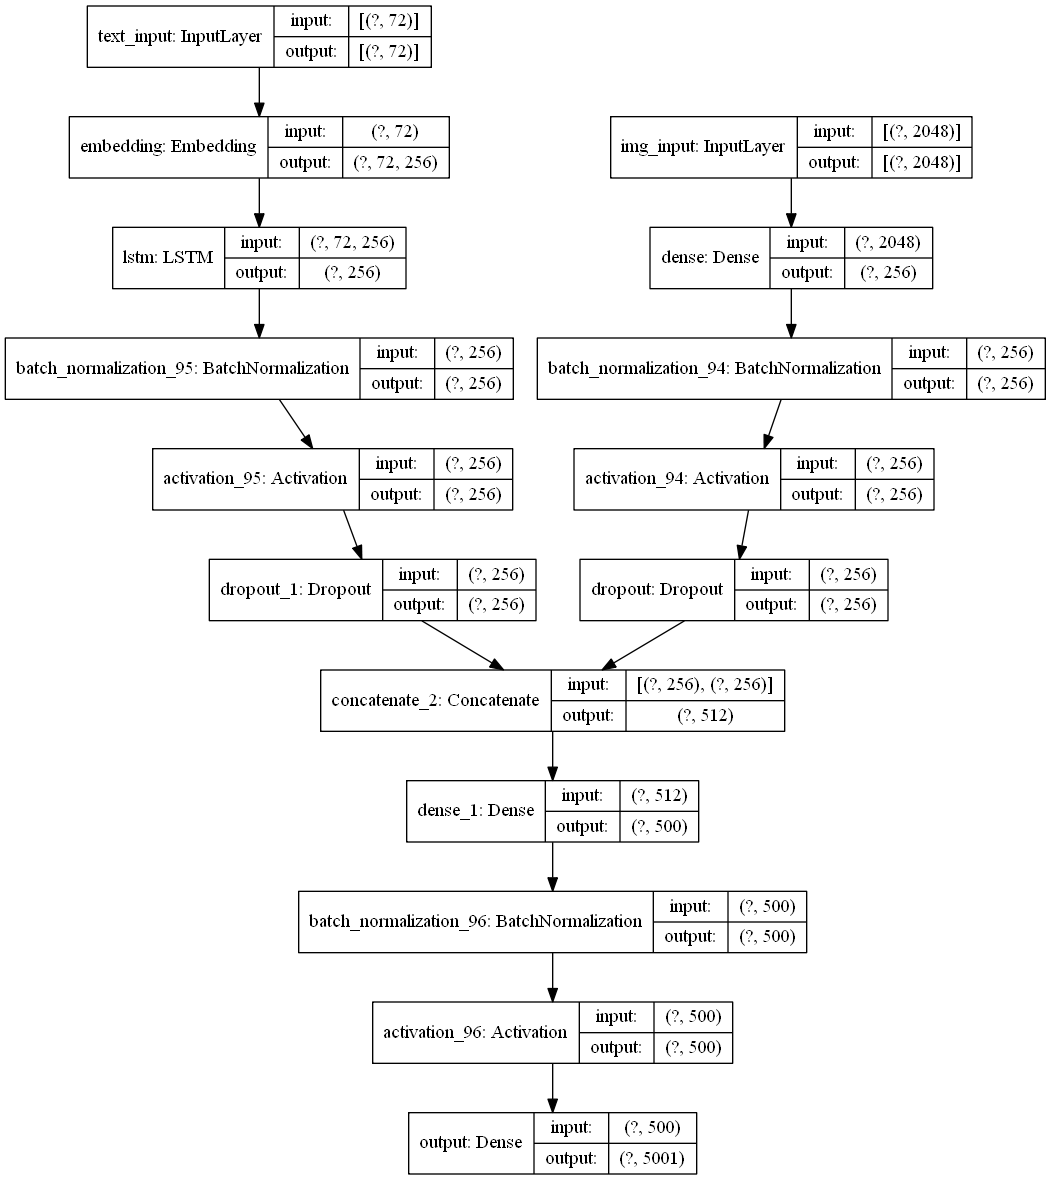

In [27]:
from IPython.display import SVG
import tensorflow as tf

%matplotlib inline
#pydot.
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [28]:
len(image_desc)

31783

In [29]:
num_photos_per_batch = 3
steps = len(train_desc)//num_photos_per_batch
print(num_photos_per_batch, steps)

3 4000


In [30]:
#gen = data_gen(train_desc, num_photos_per_batch)
early_stopping = tf.keras.callbacks.EarlyStopping()


In [ ]:
EPOCHS = 2
gen = data_gen(image_list, word_list_vec )
for i in tqdm(range(EPOCHS)) :
    model.fit_generator(gen, epochs=2, steps_per_epoch=steps, use_multiprocessing=True)
    

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 4000 steps
Epoch 1/2


In [ ]:
model.save(os.path.join(add_path,'cap_model.h5'))

In [ ]:
image_list_path = "./data/captions/image_list.pkl"
with open(image_list_path, "wb") as fp:
    pickle.dump(image_list, fp)
encoding_train_dict_path = "./data/captions/encoding_train_dict.pkl"
with open(encoding_train_dict_path, "wb") as fp:
    pickle.dump(encoding_train_dict, fp)
tokenizer_path = "./data/captions/tokenizer.pkl"
with open(tokenizer_path, "wb") as fp:
    pickle.dump(tokenizer, fp)
image_desc_path = "./data/captions/image_desc.pkl"
with open(image_desc_path, "wb") as fp:
    pickle.dump(image_desc, fp)

In [ ]:
START = "starttkn"
STOP = "endtkn"

In [ ]:
idxtoword = tokenizer.index_word
wordtoidx = tokenizer.word_index
#idxtoword

In [ ]:
def generateCaption(photo):
    in_text = START
    for i in range(20):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = preprocessing.sequence.pad_sequences([sequence], maxlen=max_len)
        #print(tokenizer.sequences_to_texts(sequence))
        #print(sequence)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        print(yhat)
        #print(yhat)
        word = idxtoword[yhat]
        #print('predict word : ', word)
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
for z in range(1):
  pic = list(encoding_train_dict.keys())[z]
  image = encoding_train_dict[pic].reshape((1,OUTPUT_DIM))
  print(pic)
  x=plt.imread(pic)
  plt.imshow(x)
  plt.show()
  print("Caption:",generateCaption(image))
  print("_____________________________________")

In [ ]:
import winsound as ws

def beepsound():
    freq = 2000    # range : 37 ~ 32767
    dur = 500     # ms
    ws.Beep(freq, dur) # winsound.Beep(frequency, duration)
    ws.Beep(freq, dur) # winsound.Beep(frequency, duration)

print(beepsound())